# A MARKOV MODEL FOR THE SPREAD OF HEPATISIS C VIRUS

In [1]:
import numpy as np

from scipy.stats import expon
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from time import time

time_notebook = time()

In [2]:
# Parameter used
alpha = 1
mu1 = .1
mu2 = .2
r = 1
lbda = 5
pI = .8
N = 100

## Limit of the deterministic differential system

In [3]:
def sol_lim(p, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI):
    a = alpha*p - mu1 + mu2
    b = r + lbda
    c = r*mu1 + lbda*(1 - pI)*mu2
    
    s1 = (a*b - c + np.sign(a)*np.sqrt((a*b - c)**2 + 4*a*b*r*mu1))/(2*a*mu1)
    s2 = (b - mu1*s1)/mu2
    
    return s1, s2

In [4]:
p = 0.8
s1, s2 = sol_lim(p)
print(s1, s2)

57.81967668825687 1.0901616558715643


# Markov modelization

In [5]:
def q1(n1, n2, r=r, lbda=lbda, pI=pI):
    if n1 + n2 == 0: # convention 0/0 = 0
        return r
    return r + lbda*pI*n1/(n1+n2)

def q2(n1, n2, mu1=mu1):
    return mu1 * n1

def q3(n1, n2, p, alpha=alpha):
    return alpha * p * n2 * n1 / (n1 + n2)

def q4(n1, n2, lbda=lbda, pI=pI):
    if n1 + n2 == 0: # convention 0/0 = 0
        return r
    return lbda * (1 - pI * n1 / (n1 + n2))

def q5(n1, n2, mu2=mu2):
    return mu2 * n2


In [6]:
def make_transition(n1, n2, transi):
    """
    Actualize n1 and n2 according to the transition
    """
    if transi == 0:
        return (n1 + 1, n2)
    elif transi == 1:
        return (n1 - 1, n2)
    elif transi == 2:
        return (n1 + 1, n2 - 1)
    elif transi == 3:
        return (n1, n2 + 1)
    elif transi == 4:
        return (n1, n2 - 1)

In [7]:
def gen_transition(n1, n2, p, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI, N=N):
    """
    Take the first possible that comes according to random variables taken for each law 
    """
    a1 = q1(n1, n2, r=r, lbda=lbda, pI=pI)
    a4 = q4(n1, n2, lbda=lbda, pI=pI)
 
    r = [np.inf for _ in range(5)]
    r[0] = expon.rvs(scale=1./a1)
    r[3] = expon.rvs(scale=1./a4)
    
    if n1 > 0 and n2 > 0:
        a3 = q3(n1, n2, p, alpha=alpha)
        r[2] = expon.rvs(scale=1./a3)
    if n1 > 0: # possible for n1 to diminish
        a2 = q2(n1, n2, mu1=mu1)
        r[1] = expon.rvs(scale=1./a2)
    if n2 > 0: # possible for n2 to diminish       
        a5 = q5(n1, n2, mu2=mu2)
        r[4] = expon.rvs(scale=1./a5)

    transi = np.argmin(r)
    return (transi, r[transi])

In [8]:
def trajectory(n1_start, n2_start, T, p, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI, N=N):
    t = 0
    times = [0]
    n1, n2 = n1_start, n2_start
    X1, X2 = [n1], [n2]
    while t < T:
        # we keep the first one after T for interpolating until T
        transi, dt = gen_transition(n1, n2, p, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI, N=N)
        t += dt
        n1, n2 = make_transition(n1, n2, transi)
        X1.append(n1)
        X2.append(n2)
        times.append(t)
        
    return X1, X2, times

In [9]:
X1, X2, t = trajectory(100, 100, 1000, 0.8)

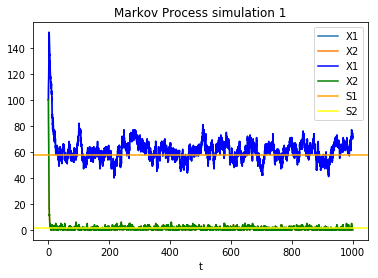

In [10]:
fig1 = plt.figure()
plt.plot(t, X1, label='X1')
plt.plot(t, X2, label='X2')
plt.plot(t, X1, label='X1', color='blue')
plt.plot(t, X2, label='X2', color='green')
plt.axhline(y=s1, label='S1', color='orange')
plt.axhline(y=s2, label='S2', color='yellow')
plt.xlabel('t')
plt.legend()
plt.title('Markov Process simulation 1')
plt.show()

In [11]:
# saving plot to file
fig1.set_size_inches(10, 10)  # 1 inch = 2.54cm
fig1.savefig('markov_simulation_1.png', bbox_inches='tight')


In [12]:
def prevalence(n1_start, n2_start, T, p, n_trajectories=10000, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI, N=N):
        trajectories = [trajectory(n1_start, n2_start, T, p, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI, N=N) \
                          for _ in range(n_trajectories)] 
        prev = np.sum([(x1[-1] / (x1[-1] + x2[-1])) for x1, x2, _ in trajectories]) / n_trajectories
        return prev

In [13]:
# Fastest simulation

def rv(dp):
    """
    Generate a random variable according to a discrete probability distribution :
        dp = [ p(i) ]_i
    """
    v = np.random.rand()
    cdf = np.cumsum(dp)
    i = 0
    while i < len(dp) and v > cdf[i]:
        i += 1
    return i

def gen_transition2(n1, n2, p, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI, N=N):
        """
        This method use two random variables :
        the exponential for the time before next transition (the min of all exponentials involved)
        one for selecting the transition
        """
        v = np.random.rand() # for the transition selection
        # 1 and 4 are always possible
        a1 = q1(n1, n2, r=r, lbda=lbda, pI=pI)
        a4 = q4(n1, n2, lbda=lbda, pI=pI)
        dp = np.array([a1, 0, 0, a4, 0])
        a = a1 + a4
        if n1 > 0:
            a2 = q2(n1, n2, mu1=mu1)
            a += a2
            dp[1] = a2
        if n2 > 0:
            a3 = q3(n1, n2, p, alpha=alpha)
            a5 = q5(n1, n2, mu2=mu2)
            a += a3 + a5
            dp[2] = a3
            dp[4] = a5
        dp /= a # making dp a probability distribution between transitions
        transi = rv(dp)
        # time before next transition
        t = expon.rvs(scale=1./a)
        return transi, t

def trajectory2(n1_start, n2_start, T, p, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI, N=N):
    t = 0
    times = [0]
    n1, n2 = n1_start, n2_start
    X1, X2 = [n1], [n2]
    while t < T:
        # we keep the first one after T for interpolating until T
        transi, dt = gen_transition2(n1, n2, p, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI, N=N)
        t += dt
        n1, n2 = make_transition(n1, n2, transi)
        X1.append(n1)
        X2.append(n2)
        times.append(t)
        
    return X1, X2, times

def prevalence2(n1_start, n2_start, T, p, n_trajectories=10000, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI, N=N):
        trajectories = [trajectory2(n1_start, n2_start, T, p, alpha=alpha, mu1=mu1, mu2=mu2, r=r, lbda=lbda, pI=pI, N=N) \
                          for _ in range(n_trajectories)] 
        prev = np.mean([(x1[-1] / (x1[-1] + x2[-1])) for (x1, x2, _) in trajectories])
        return prev, trajectories

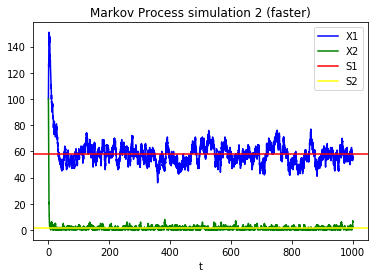

In [14]:
X1, X2, t = trajectory2(100, 100, 1000, p)
fig2 = plt.figure()
plt.plot(t, X1, label='X1', color='blue')
plt.plot(t, X2, label='X2', color='green')
plt.axhline(y=s1, label='S1', color='red')
plt.axhline(y=s2, label='S2', color='yellow')
plt.xlabel('t')
plt.title('Markov Process simulation 2 (faster)')
plt.legend()
plt.show()


In [15]:
# saving plot to file
fig2.set_size_inches(10, 10)  # 1 inch = 2.54cm
fig2.savefig('markov_simulation_2.png', bbox_inches='tight')

# Prevalence calculation by simulation

In [16]:
# Took 300 sec
# result = 0.98161935019830893
execute = False
if execute:
    K = 1000
    t = time()
    prev = [prevalence(50, 50, 100, 0.8) for i in range(K)]   
    t = time() - t
    print(t)
    np.mean(prev)

In [17]:
# Took 3065 sec for a difference of order 10^-3 so 1000 trajectories will be sufficient...
# result : 0.98124351597952064
execute = False
if execute: 
    K = 10000
    t = time()
    prev10000 = [prevalence(50, 50, 100, 0.8) for i in range(K)]   
    t = time() - t
    print(t)
    np.mean(prev10000)

# Influence of p on prevalence

In [18]:
# deterministic model
p_vals_det = np.arange(0, 1, .01)
prevalence_f = lambda x: x[0]/(x[0] + x[1])
t = time()
prev_det = [prevalence_f(sol_lim(p)) for p in p_vals_det]
t = time() - t
print(t)

0.0008313655853271484


In [ ]:
# simulation
K = 100
p_vals_sim = np.arange(.1, 1, .1)
t = time()
prev_sim = [np.mean([prevalence(50, 50, 100, p) for _ in range(K)]) for p in p_vals_sim]   
t = time() - t
print(t)

In [ ]:
fig3 = plt.figure()
plt.plot(p_vals_det, prev_det, label='Deterministic', color='blue')
plt.scatter(p_vals_sim, prev_sim, label='Simulated', color='orange')
plt.legend()
plt.xlabel('p')
plt.ylabel('prevalence')
plt.title('Influence of p on prevalence')
plt.show()

In [ ]:
# saving plot to file
fig3.set_size_inches(10, 10)  # 1 inch = 2.54cm
fig3.savefig('prevalence.png', bbox_inches='tight')

In [ ]:
time_notebook = time() - time_notebook
print('Notebook executed in %ds' % time_notebook)